## training

In [1]:
import helper.get_image
import numpy as np

FOLDER_PATH = 'F://term7//CV//reference'

# random
train_size = 200
test_size = 100
val_size = 40

img_range = np.arange(1, 800)
X_train_pos_idx, X_test_pos_idx, X_val_pos_idx = helper.get_random_indices(img_range, train_size, test_size, val_size)
X_train_neg_idx, X_test_neg_idx, X_val_neg_idx = helper.get_random_indices(img_range, train_size, test_size, val_size)

X_train, Y_train = helper.get_concrete_data(X_train_pos_idx, X_train_neg_idx, path = FOLDER_PATH)
#X_test , Y_test  = helper.get_concrete_data(X_test_pos_idx, X_test_neg_idx, path = FOLDER_PATH)
#X_val  , Y_val   = helper.get_concrete_data(X_val_pos_idx, X_val_neg_idx, path = FOLDER_PATH)

print( X_train.shape, Y_train.shape )
#print( X_test.shape , Y_test.shape  )
#print( X_val.shape  , Y_val.shape   )

(400, 227, 227) (400,)


In [ ]:
# from filters.filter import GrayscaleNormalizer
# normalizer = GrayscaleNormalizer()
# X_train[:] = normalizer(X_train[:][0]) 
# X_train_flat = X_train.reshape(X_train.shape[0],-1)

In [5]:
from filters.bilateral import bilateral_canny
bilateral_canny = bilateral_canny()
for idx in range(X_train.shape[0]):
    X_train[idx] = bilateral_canny.bilateral_canny_img(X_train[idx]) 

In [7]:
X_train_flat = X_train.reshape(X_train.shape[0],-1)

In [8]:
# train a logistic model
from sklearn import linear_model
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train_flat, Y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# video generation

#### video to frame

In [61]:
video_file = "F://term7//CV//ProjectTrail//videos//File_003.mov"
frame_file = "F://term7//CV//ProjectTrail//File_003frame"
from video import video
v = video(video_file)
v.video_to_frames(frame_file)


Converting video..

Done extracting frames.
416 frames extracted
It took 32 seconds forconversion.


In [13]:
import cv2

In [14]:
def norm_dilate_median(origin_img):
    result_planes = []
    result_norm_planes = []
    plane = origin_img.astype(np.uint8)
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    cv2.absdiff(plane, bg_img)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img= diff_img
    norm_img = cv2.normalize(diff_img, norm_img, alpha=0, 
                             beta=255, norm_type=cv2.NORM_MINMAX, 
                             dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)

    return result_norm

In [15]:
def adaptiveThreshold(origin_img):
    return cv2.adaptiveThreshold(origin_img ,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,5)

In [16]:
def save_image(img, dst, filename):
    if not os.path.exists(dst):
        os.mkdir(dst)  
    cv2.imwrite(os.path.join(dst , filename), img)
    cv2.waitKey(0)

In [64]:
from helper import rolling_window, shade_area

def generate_shadowed_img(origin, cannyed, stride = (106,112), window_size = (227, 227)):
    
    
    imgs = rolling_window(cannyed, window_size, stride)
    nx, ny = imgs.shape[0], imgs.shape[1]
    
    plt.figure(figsize=(20, 20 * nx / ny))
    
    result = logistic.predict(imgs.reshape(nx * ny, -1)).reshape(nx, ny)
    boxed = shade_area(origin, imgs, result, window_size, stride)
    
    return boxed

In [38]:
from helper import rolling_window, shade_area

def generate_sub_frames(origin, dst, count, stride = (106,112), window_size = (227, 227)):
    imgs = rolling_window(origin, window_size, stride)
    nx, ny = imgs.shape[0], imgs.shape[1]
    
    
    for i in range(nx):
        for j in range(ny):
            count += 1
            sub_img = imgs[i, j]
            filename = "%#06d.jpg" % (count)
            save_image(sub_img, dst, filename)
    return count
#     result = logistic.predict(imgs.reshape(nx * ny, -1)).reshape(nx, ny)
#     boxed = shade_area(origin, imgs, result, window_size, stride)
#     return boxed



In [18]:
def tophat(img, element=(2,2)):
    img = np.uint8(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,element)
    myfiltered = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return myfiltered

In [67]:
import time

In [65]:
import os
INPUT_PATH = "F:\\term7\\CV\\ProjectTrail\\File_003frame\\"
OUTPUT_PATH  = "F:\\term7\\CV\\ProjectTrail\Output003adath\\"

input_format = 'jpg'

from filters.bilateral import bilateral_canny
bilateral_canny_video = bilateral_canny()

import time
time_start = time.time()
time_pre = time.time()
time_norm = 0
time_canny =  0
time_predict_and_shadow = 0
time_save = 0

count = 0
frameid = 0
time = False

for f in os.listdir(INPUT_PATH):
    if f.endswith(input_format):
        image_path = os.path.join(INPUT_PATH, f)
        frame = cv2.imread(image_path)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # reduce shadow by dilate, median, or threshold

        if time:
            time_pre = time.time()
#         frame_shadow_reduced = norm_dilate_median(gray_frame)
        frame_shadow_reduced = adaptiveThreshold(gray_frame)
        if time:
            time_norm += time.time() - time_pre
            time_pre = time.time()
            
        # generate output after canny filter, or tophat
        frame_after_canny = bilateral_canny_video.canny_img(frame_shadow_reduced)
#         frame_after_canny = tophat(frame_shadow_reduced,element=(6,6))
        if time:
            time_canny += time.time() - time_pre
            time_pre = time.time()    
        
        frame_final = generate_shadowed_img(frame, frame_after_canny)
        time_predict_and_shadow += time.time() - time_pre
        time_pre = time.time()
        
        # save to folder
        save_image(cv2.cvtColor(frame_final, cv2.COLOR_RGB2BGR), OUTPUT_PATH, f)
        time_save= time.time() - time_pre
        time_pre = time.time()    
        
if time:
    print("total time for frames generation is {}".format(time.time()-time_start))
    print("time norm{}".format(time_norm))
    print("time_canny{}".format(time_canny))
    print("time_predict_and_shadow{}".format(time_predict_and_shadow))
    print("time_save{}".format(time_save))

C:\Users\ntjin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


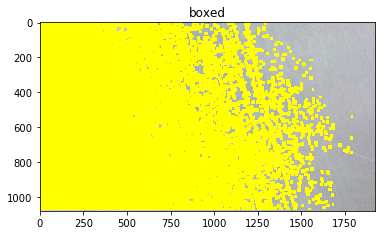

-1

In [60]:
plt.imshow(frame_final)
plt.title('boxed')
plt.show()

dst = "F:\\term7\\CV\\ProjectTrail\\"
filename = "a.jpg"
if not os.path.exists(dst):
    os.mkdir(dst)  
cv2.imwrite(os.path.join(dst , filename), cv2.cvtColor(frame_final, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)

stats:

for file 000, consists of 539 images 

total time for frames generation is 365.9983892440796

time norm9.641156435012817

time_canny4.354477405548096

time_predict_and_shadow291.21285343170166

time_save0.05203747749328613

## video gem

#### frames to video

In [68]:

time_start = time.time()
#video_file = "F://term7//CV//ProjectTrail//videos//File_001.mov"
frame_file =  "F:\\term7\\CV\\ProjectTrail\Output003adath\\"
output_video_loc =  "F://term7//CV//ProjectTrail//videos//IMG_5161_bilate.mov"
from video import video
v = video(video_file)
v.frames_to_video(output_video_loc, input_loc=frame_file, debug=True)
print("total time video saving {}".format(time.time()-time_start))

[INFO] fps not defined from parameter or input. getting fps from origional video
[INFO] actual fps is 30
[INFO] no specificed image file format for input frames. JPG will be used
press q to exit cv2 window
[INFO] reading 00000.jpg
[INFO] reading 00001.jpg
[INFO] reading 00002.jpg
[INFO] reading 00003.jpg
[INFO] reading 00004.jpg
[INFO] reading 00005.jpg
[INFO] reading 00006.jpg
[INFO] reading 00007.jpg
[INFO] reading 00008.jpg
[INFO] reading 00009.jpg
[INFO] reading 00010.jpg
[INFO] reading 00011.jpg
[INFO] reading 00012.jpg
[INFO] reading 00013.jpg
[INFO] reading 00014.jpg
[INFO] reading 00015.jpg
[INFO] reading 00016.jpg
[INFO] reading 00017.jpg
[INFO] reading 00018.jpg
[INFO] reading 00019.jpg
[INFO] reading 00020.jpg
[INFO] reading 00021.jpg
[INFO] reading 00022.jpg
[INFO] reading 00023.jpg
[INFO] reading 00024.jpg
[INFO] reading 00025.jpg
[INFO] reading 00026.jpg
[INFO] reading 00027.jpg
[INFO] reading 00028.jpg
[INFO] reading 00029.jpg
[INFO] reading 00030.jpg
[INFO] reading 0003

[INFO] reading 00321.jpg
[INFO] reading 00322.jpg
[INFO] reading 00323.jpg
[INFO] reading 00324.jpg
[INFO] reading 00325.jpg
[INFO] reading 00326.jpg
[INFO] reading 00327.jpg
[INFO] reading 00328.jpg
[INFO] reading 00329.jpg
[INFO] reading 00330.jpg
[INFO] reading 00331.jpg
[INFO] reading 00332.jpg
[INFO] reading 00333.jpg
[INFO] reading 00334.jpg
[INFO] reading 00335.jpg
[INFO] reading 00336.jpg
[INFO] reading 00337.jpg
[INFO] reading 00338.jpg
[INFO] reading 00339.jpg
[INFO] reading 00340.jpg
[INFO] reading 00341.jpg
[INFO] reading 00342.jpg
[INFO] reading 00343.jpg
[INFO] reading 00344.jpg
[INFO] reading 00345.jpg
[INFO] reading 00346.jpg
[INFO] reading 00347.jpg
[INFO] reading 00348.jpg
[INFO] reading 00349.jpg
[INFO] reading 00350.jpg
[INFO] reading 00351.jpg
[INFO] reading 00352.jpg
[INFO] reading 00353.jpg
[INFO] reading 00354.jpg
[INFO] reading 00355.jpg
[INFO] reading 00356.jpg
[INFO] reading 00357.jpg
[INFO] reading 00358.jpg
[INFO] reading 00359.jpg
[INFO] reading 00360.jpg


# last testing on the video capture near canteen

(1080, 1920)
(1080, 1920)


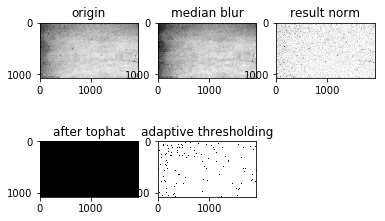

In [35]:
# input is called origin_img

PATH = "F:\\term7\\CV\\ProjectTrail\\IMG_5161frame\\"
origin_img = PATH + "00541.jpg"
origin_img = cv2.imread(origin_img, 0).astype(np.float32)

result_planes = []
result_norm_planes = []
plane = origin_img.astype(np.uint8)
dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))

plt.subplot(231)
plt.imshow(origin_img, cmap='gray')
plt.title('origin')

dilated_img = dilated_img
bg_img = cv2.medianBlur(dilated_img, 5)

plt.subplot(232)
plt.imshow(bg_img, cmap='gray')
plt.title('median blur')

print(plane.shape) 
print(bg_img.shape)
cv2.absdiff(plane, bg_img)

diff_img = 255 - cv2.absdiff(plane, bg_img)
norm_img= diff_img
norm_img = cv2.normalize(diff_img, norm_img, alpha=0, 
                         beta=255, norm_type=cv2.NORM_MINMAX, 
                         dtype=cv2.CV_8UC1)
result_planes.append(diff_img)
result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm2 = cv2.merge(result_norm_planes)

result_morp = tophat(result_norm2,element=(1,1))

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm2)

plt.subplot(233)
plt.imshow(result, cmap='gray')
plt.title('result norm')

plt.subplot(234)
plt.imshow(result_morp, cmap='gray')
plt.title('after tophat')

adath = adaptiveThreshold(plane)
plt.subplot(235)
plt.imshow(adath, cmap='gray')
plt.title('adaptive thresholding')


plt.show()